# ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import sys
from importlib import reload
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, str): 
        text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): 
            try:
                text = text.decode('utf8')
            except UnicodeDecodeError:
                try:
                    text = text.decode('cp1251')
                except UnicodeDecodeError:
                    text = text.decode('koi8_r')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = []
        self._a = []
        self._in_title = False
        self._in_a = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')
            if self._in_title:
                self._title.append(text + ' ')
            if self._in_a:
                self._a.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._in_a = True

    def handle_endtag(self, tag):
        if tag == 'title':
            self._in_title = False
        elif tag == 'a':
            self._in_a = False

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip(), ''.join(self._title).strip(), ''.join(self._a).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    text, title, a = to_text(raw_html)
    text = tokenizer(text.lower())
    title = tokenizer(title.lower())
    a = tokenizer(a.lower())
    return text, title, a

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a / b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
def calc_features(url, html_data):
    words, title, a = html2word(html_data)
    words = list(words)
    title = list(title)
    a = list(a)
    words_num = len(words)
    avg_word_len = 0
    title_words_num = len(title)    
    anchor_words_num = len(a)
    compression_level = 0
    
    for word in words:
        avg_word_len += len(word)
    avg_word_len /= words_num
    
    text = ' '.join(words)
    compr = zlib.compress(bytes(text.encode()))
    compression_level = safe_divide(sys.getsizeof(text), sys.getsizeof(compr))
    
    return [words_num, avg_word_len, title_words_num, anchor_words_num, compression_level, ' '.join(words), ' '.join(title), ' '.join(a)]

In [11]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<a>
spam.com
</a>
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[8, 3.5, 2, 2, 1.6941176470588235, 'заголовок ololo спам 1 2 3 spam com', 'заголовок ololo', 'spam com']


In [12]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(train_input_file_name, test_input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    train_docs = []
    test_docs = []
    # if input_file_name.endswith('gz') else open(input_file_name) :            
    with gzip.open(train_input_file_name) as input_file: 
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split(b'\t')
            url_id = int(parts[0])
            mark = bool(int(parts[1]))
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)
            train_docs.append(DocItem(url_id, mark, url, features))
                     
    with gzip.open(test_input_file_name) as input_file: 
        headers = input_file.readline()
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split(b'\t')
            url_id = int(parts[0])
            mark = bool(int(parts[1]))
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)
            test_docs.append(DocItem(url_id, mark, url, features))
        
    return train_docs, test_docs

In [13]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=1000)

def get_features(train_row, test_row):
    train_words = []
    test_words = []
    train_title = []
    test_title = []
    train_a = []
    test_a = []
    train_docs = []
    test_docs = []
    for doc in train_row:
        train_words.append(doc.features[-3])
        train_title.append(doc.features[-2])
        train_a.append(doc.features[-1])
    for doc in test_row:
        test_words.append(doc.features[-3])
        test_title.append(doc.features[-2])
        test_a.append(doc.features[-1])
        
    vectorizer.fit(train_words + test_words)
    train_tfidf = vectorizer.transform(train_words)
    test_tfidf = vectorizer.transform(test_words)
            
    for i in range(len(train_words)):
        train_docs.append(DocItem(train_row[i].doc_id, train_row[i].is_spam,
                          train_row[i].url,
                          train_row[i].features[:-3] + train_tfidf[i].todense().tolist()[0]))
                         # train_row[i].features[:-3] + train_tfidf[i].todense().tolist()[0]))
        #features[i] = tfidf[i].todense().tolist()[0]
        
    for i in range(len(test_words)):
        test_docs.append(DocItem(test_row[i].doc_id, test_row[i].is_spam,
                         test_row[i].url,
                         test_row[i].features[:-3] + test_tfidf[i].todense().tolist()[0]))
        #features[i] = tfidf[i].todense().tolist()[0]
    
    return train_docs, test_docs

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [14]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

train_row, test_row = load_csv(TRAIN_DATA_FILE, TEST_DATA_FILE, calc_features)

19:16:12 INFO:Complete items 00000
19:17:07 INFO:Complete items 01000
19:17:53 INFO:Complete items 02000
19:18:41 INFO:Complete items 03000
19:19:28 INFO:Complete items 04000
19:20:19 INFO:Complete items 05000
19:21:06 INFO:Complete items 06000
19:21:57 INFO:Complete items 07000
19:21:59 INFO:Complete items 00000
19:23:10 INFO:Complete items 01000
19:24:15 INFO:Complete items 02000
19:25:15 INFO:Complete items 03000
19:26:08 INFO:Complete items 04000
19:26:59 INFO:Complete items 05000
19:28:01 INFO:Complete items 06000
19:28:56 INFO:Complete items 07000
19:29:52 INFO:Complete items 08000
19:30:48 INFO:Complete items 09000
19:32:03 INFO:Complete items 10000
19:32:57 INFO:Complete items 11000
19:33:53 INFO:Complete items 12000
19:34:44 INFO:Complete items 13000
19:35:43 INFO:Complete items 14000
19:36:41 INFO:Complete items 15000
19:37:45 INFO:Complete items 16000


CPU times: user 21min 32s, sys: 2.61 s, total: 21min 35s
Wall time: 21min 35s


In [15]:
len(train_row[2].features)

8

In [16]:
%%time

train_docs, test_docs = get_features(train_row, test_row)

CPU times: user 3min 22s, sys: 2.72 s, total: 3min 25s
Wall time: 3min 25s


In [17]:
len(train_docs[2].features)

1005

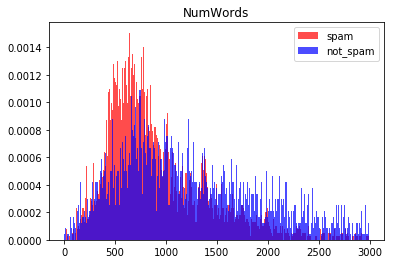

In [37]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

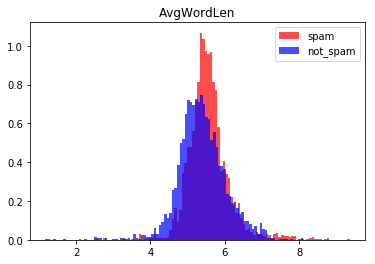

In [38]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

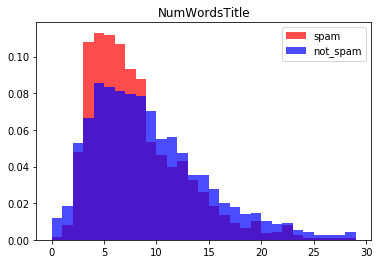

In [39]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

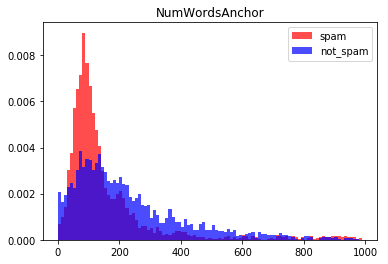

In [40]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 1000, 10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

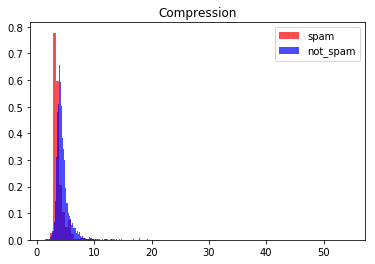

In [41]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('Compression')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [18]:
from IPython.display import clear_output

def train(network, train_loader, test_loader, epochs, learning_rate, ravel_init=False, optim=torch.optim.Adam):
    loss = nn.BCELoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append(((prediction.data.numpy() > 0.5)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                if ravel_init:
                    X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append(((prediction.data.numpy() > 0.5)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) BCE: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [19]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [20]:
class Classifier:
    
    def __init__(self, epochs=50, lr=0.00001):
        self.epochs = epochs
        self.lr = lr

    def predict(self, doc):
        X = np.zeros((len(doc.features)))
        X[:] = doc.features
        return self.model(torch.from_numpy(X)).data.numpy()[0]
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):
        X = np.zeros((len(docs), len(docs[0].features)))
        y = np.zeros(len(docs))
        for doc_num, doc in enumerate(docs):                            
            X[doc_num] = doc.features
            y[doc_num] = doc.is_spam
        self.model = nn.Sequential(
            nn.Linear(len(docs[0].features), 300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid()).double()
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42)
        train_set = MyDataset(X_train, y_train)
        test_set = MyDataset(X_test, y_test)
        train_loader = DataLoader(train_set, batch_size=64)
        test_loader = DataLoader(test_set, batch_size=64)
        train(self.model, train_loader, test_loader, epochs=self.epochs, learning_rate=self.lr)

Epoch 493... (Train/Test) BCE: 0.067/0.095	Accuracy: 0.523/0.560


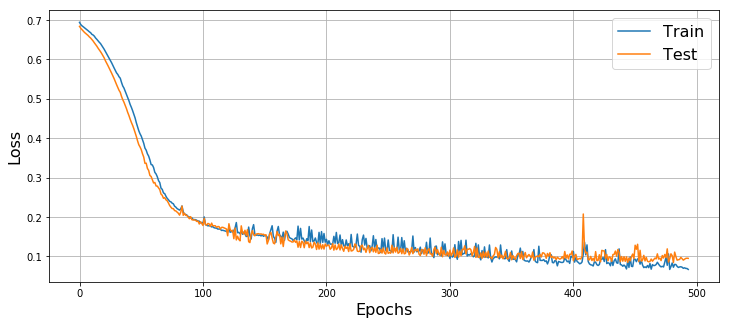

In [21]:
classifier = Classifier(epochs=1000, lr=0.00002)
classifier.train(train_docs)

In [ ]:
#Посмотреть, что предсказывается для тестового html
#classifier.predict(DocItem(0, 0, test_url , test_features))

** Рисуем графики **

20:45:46 INFO:Complete items 00000
20:45:49 INFO:Complete items 01000
20:45:51 INFO:Complete items 02000
20:45:53 INFO:Complete items 03000
20:45:56 INFO:Complete items 04000
20:45:58 INFO:Complete items 05000
20:46:00 INFO:Complete items 06000
20:46:02 INFO:Complete items 07000


threshold 0
	class_prec 0.5833333333333334, class_recall 1.0, class_F1 0.7368421052631579
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.3684210526315789
threshold 0.01
	class_prec 0.719187675070028, class_recall 0.9997566317838891, class_F1 0.8365746868954282
	not_class_prec 0.9992492492492493, not_class_recall 0.4534923339011925, not_class_F1 0.6238575111319428
		MacroF1Mesure 0.7302160990136854
threshold 0.02
	class_prec 0.7504567044208988, class_recall 0.9997566317838891, class_F1 0.8573515600542628
	not_class_prec 0.9993630573248408, not_class_recall 0.5345826235093697, not_class_F1 0.6965593784683686
		MacroF1Mesure 0.7769554692613156
threshold 0.03
	class_prec 0.7675635276532138, class_recall 0.9997566317838891, class_F1 0.8684071451220802
	not_class_prec 0.9994089834515366, not_class_recall 0.5761499148211243, not_class_F1 0.7309271666306463
		MacroF1Mesure 0.7996671558763633
threshold 0.04
	class_prec 0.7808401444592283, class_recall 0.9997566317

threshold 0.37000000000000016
	class_prec 0.895117144733961, class_recall 0.9948892674616695, class_F1 0.9423697556477639
	not_class_prec 0.991522002422285, not_class_recall 0.8367972742759796, not_class_F1 0.9076127124907613
		MacroF1Mesure 0.9249912340692625
threshold 0.38000000000000017
	class_prec 0.896687870146962, class_recall 0.9948892674616695, class_F1 0.9432395016151361
	not_class_prec 0.9915492957746479, not_class_recall 0.8395229982964225, not_class_F1 0.9092250922509225
		MacroF1Mesure 0.9262322969330293
threshold 0.3900000000000002
	class_prec 0.8982193888766762, class_recall 0.9944025310294475, class_F1 0.9438669438669438
	not_class_prec 0.9907815631262525, not_class_recall 0.8422487223168654, not_class_F1 0.9104972375690609
		MacroF1Mesure 0.9271820907180024
threshold 0.4000000000000002
	class_prec 0.8995594713656387, class_recall 0.9939157945972256, class_F1 0.9443866342929819
	not_class_prec 0.9900159744408946, not_class_recall 0.844633730834753, not_class_F1 0.911564

threshold 0.7400000000000004
	class_prec 0.9538280329799764, class_recall 0.9853979070333414, class_F1 0.9693559971271247
	not_class_prec 0.9785637727759914, not_class_recall 0.9332197614991482, not_class_F1 0.9553540286013255
		MacroF1Mesure 0.9623550128642251
threshold 0.7500000000000004
	class_prec 0.9558337269721304, class_recall 0.9849111706011195, class_F1 0.9701546206400576
	not_class_prec 0.9779359430604982, not_class_recall 0.9362862010221465, not_class_F1 0.9566579634464752
		MacroF1Mesure 0.9634062920432664
threshold 0.7600000000000005
	class_prec 0.9567273587136439, class_recall 0.9846678023850085, class_F1 0.9704965219477093
	not_class_prec 0.977619893428064, not_class_recall 0.937649063032368, not_class_F1 0.9572173913043478
		MacroF1Mesure 0.9638569566260285
threshold 0.7700000000000005
	class_prec 0.9585406301824212, class_recall 0.9846678023850085, class_F1 0.9714285714285714
	not_class_prec 0.9776833156216791, not_class_recall 0.9403747870528109, not_class_F1 0.958666

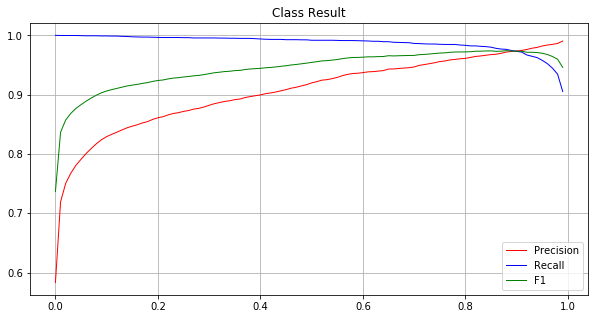

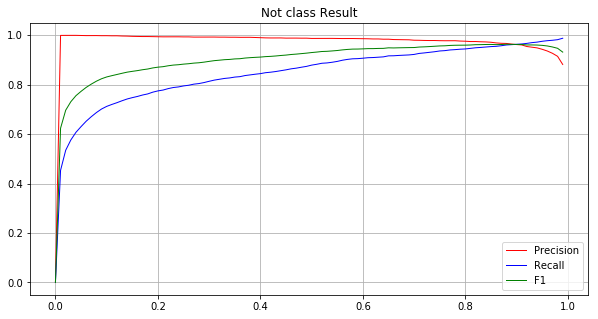

In [22]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.01, trace=1)

In [23]:
threshold = 0.88

with open('my_submission.csv', 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id', 'Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

20:47:03 INFO:Complete items 00000
20:47:05 INFO:Complete items 01000
20:47:08 INFO:Complete items 02000
20:47:10 INFO:Complete items 03000
20:47:13 INFO:Complete items 04000
20:47:16 INFO:Complete items 05000
20:47:19 INFO:Complete items 06000
20:47:22 INFO:Complete items 07000
20:47:25 INFO:Complete items 08000
20:47:28 INFO:Complete items 09000
20:47:31 INFO:Complete items 10000
20:47:33 INFO:Complete items 11000
20:47:36 INFO:Complete items 12000
20:47:38 INFO:Complete items 13000
20:47:41 INFO:Complete items 14000
20:47:44 INFO:Complete items 15000
20:47:46 INFO:Complete items 16000
